## Identify putative synthetic lethal pairs using fitness (essentiality) and expression

**Input:**
- gene scores from running CERES
- gene expression (processed) from the DepMap portal (19Q1)
- closest and all paralogs pairs processed from Ensembl

**Output:** putative synthetic lethal pairs annotated among closest/all paralog pairs from Ensembl

Version *17-07-19*: used in manuscript, has 238 / 1,819 potential SL pairs = 13%

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import altair as alt

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

# Input
file_gene_scores = get_local_data_path(['processed', 'depmap19Q1'], 'gene_scores_11_07_19.csv')
file_filtered_expr = get_local_data_path(['processed', 'depmap19Q1'], 'filtered_gene_expression.csv')
file_closest_pairs = get_local_data_path(['processed', 'ensembl93'], 'closest_pairs.csv')
file_all_pairs = get_local_data_path(['processed', 'ensembl93'], 'all_pairs.csv')

# Output
file_results_closest = get_local_data_path(['processed', 'results'], 'closest_paralog_pairs_17_07_19.csv')
file_results_all = get_local_data_path(['processed', 'results'], 'all_paralog_pairs_17_07_19.csv')

cutoff_score = -0.47

### Data

In [2]:
all_scores = pd.read_csv(file_gene_scores, index_col=0).set_index('cell_line')
all_scores[:1]

,8036,55967,55153,25940,23224,116071,114803,1967,23014,29957,...,128344,55249,84304,5869,57818,5273,84952,11046,90594,400
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-000601,-0.117838,-0.083374,-0.75716,-0.07252,-0.012776,-0.119112,0.053607,-1.092377,-0.234541,-0.018627,...,-0.18303,-0.096821,-0.092369,0.004617,0.010656,-0.008256,0.003173,-0.062839,-0.016976,-0.154559


In [3]:
# Load gene expression data and extract ensembl id from ids
all_expr = pd.read_csv(file_filtered_expr, index_col=0)
all_expr[:1]

,ENSG00000000003,ENSG00000000005,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001461,ENSG00000001561,ENSG00000001617,ENSG00000002549,ENSG00000002587,...,ENSG00000270601,ENSG00000270672,ENSG00000271079,ENSG00000271321,ENSG00000272325,ENSG00000272333,ENSG00000272636,ENSG00000273079,ENSG00000273085,ENSG00000273274
ACH-000948,3.001802,0.0,0.0,0.298658,7.42551,4.907371,4.085765,1.070389,6.013016,0.555816,...,0.0,0.0,0.536053,0.0,3.969933,2.185867,0.124328,0.0,0.0,0.028569


In [4]:
expr = all_expr.reindex(sorted(all_expr.columns), axis=1)
scores = all_scores.loc[expr.index, :]
print('Overlapping cell lines expr and fitness: ' + str(expr.shape[0]), '/', all_scores.shape[0])
print('Cell lines dropped:', all_scores[~all_scores.index.isin(scores.index)].index.values)

Overlapping cell lines expr and fitness: 554 / 558
Cell lines dropped: ['ACH-001096' 'ACH-001151' 'ACH-001735' 'ACH-001736']


### Closest pairs: compare A2 expression for A1 essential vs. A1 not essential

In [5]:
closest_pairs = pd.read_csv(file_closest_pairs, index_col=0)
print('Num closest pairs:', closest_pairs.shape[0])
display(closest_pairs[:1])

Num closest pairs: 13107


,A1_ensembl,A2_ensembl,percent_matched_in_paralog,min_seq_id,WGD,either_in_complex,in_same_complex,A1_symbol,A1_entrez,A2_symbol,A2_entrez,closest
1,ENSG00000167858,ENSG00000163060,0.375598,0.36092,WGD,False,False,TEKT1,83659,TEKT4,150483,True


In [6]:
# Filter to genes where: 
# A1 is sometimes essential - w/ essential in at least 1% of cell lines, and at most 90%
# A2 has expr data
essential_percents = (all_scores <= cutoff_score).sum() / all_scores.shape[0]
sometimes_essential_genes = essential_percents[(essential_percents >= 0.01) & (essential_percents <= 0.9)]
closest_pairs_filtered = closest_pairs[closest_pairs.A1_entrez.isin(sometimes_essential_genes.index) & 
                                       closest_pairs.A2_ensembl.isin(expr.columns)]
print('Closest pairs to test:', closest_pairs_filtered.shape[0], ', A1s:', closest_pairs_filtered.A1_ensembl.nunique())
print('A1s w/ multiple closest A2s:', closest_pairs_filtered[closest_pairs_filtered.duplicated(subset=['A1_ensembl'], keep=False)].A1_ensembl.nunique())

# Among A1 duplicates, drop a random pair, but make sure to include ENO1-ENO2 (a known SL)
# Exact results vary slights (~ +/- 8 SLs depending on the exact pairs chosen to test)
closest_pairs_to_test = closest_pairs_filtered[~((closest_pairs_filtered.A1_symbol == 'ENO1') & (closest_pairs_filtered.A2_symbol != 'ENO2'))]
idx = np.random.permutation(np.arange(len(closest_pairs_to_test)))
closest_pairs_to_test = closest_pairs_to_test.iloc[idx].drop_duplicates(subset=['A1_ensembl'])

# To re-test previously tested pairs instead
tested_pairs = pd.read_csv(file_results_closest)[['A1','A2']]
closest_pairs_to_test = pd.merge(closest_pairs_filtered, tested_pairs.rename(columns={'A1':'A1_symbol','A2':'A2_symbol'}))

assert(closest_pairs_to_test.shape[0] == closest_pairs_to_test.A1_ensembl.nunique())

Closest pairs to test: 1875 , A1s: 1819
A1s w/ multiple closest A2s: 50


In [7]:
def test_diff_in_A2_expression(pair):
    df = pd.concat([expr.loc[:, pair['A2_ensembl']], scores.loc[:, str(pair['A1_entrez'])]], axis=1)
    df.columns = ['A2_expr', 'A1_fitness']
    # Test whether expression of A2 is greater when A1 is not essential, or vice versa
    expr_NE = df[df.A1_fitness > cutoff_score].A2_expr
    expr_E = df[df.A1_fitness <= cutoff_score].A2_expr
    if expr_E.shape[0] == 0 or expr_NE.shape[0] == 0:
        print('All expr == 0', pair.A1_symbol, pair.A2_symbol)
        return
    #mw_p = stats.mannwhitneyu(expr_NE, expr_E, alternative='two-sided').pvalue
    ttest_p = stats.ttest_ind(expr_NE, expr_E).pvalue # 2-sided
    return pd.Series([pair.A1_symbol, pair.A2_symbol, ttest_p, expr_NE.mean(), expr_E.mean()], 
                     index=['A1', 'A2', 'ttest_p', 'A2_expr_A1_NE', 'A2_expr_A1_E'])

def test_pairs(pairs):
    # Test if there is a significant difference in expression
    results = pairs.apply(lambda x: test_diff_in_A2_expression(x), axis=1)
    # Correct p-values for multiple testing
    results = results.dropna()
    results = results.assign(ttest_p_correct = fdrcorrection(results.ttest_p.values)[1])
    # Mark potential synthetic lethals with a flag
    results = results.assign(SL = (results.ttest_p_correct < 0.1) & (results.A2_expr_A1_NE > results.A2_expr_A1_E))
    # Merge back other pair info
    results = pd.merge(results, pairs[['A1_symbol','A2_symbol','percent_matched_in_paralog','WGD','either_in_complex','in_same_complex',
                                       'A1_ensembl','A2_ensembl','A1_entrez','A2_entrez']].rename(columns={'A1_symbol':'A1','A2_symbol':'A2'}))
    return results

In [8]:
# Test if there is a significant difference in expression
results_closest_pairs = test_pairs(closest_pairs_to_test)
SLs = results_closest_pairs[results_closest_pairs.SL==True]
print('Num SL pairs/A1s: %d / %d --> %.3f%%' % (SLs.A1.nunique(), results_closest_pairs.A1.nunique(), 
                                                SLs.A1.nunique() / results_closest_pairs.A1.nunique() * 100))
results_closest_pairs[:1]

Num SL pairs/A1s: 238 / 1819 --> 13.084%


,A1,A2,ttest_p,A2_expr_A1_NE,A2_expr_A1_E,ttest_p_correct,SL,percent_matched_in_paralog,WGD,either_in_complex,in_same_complex,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
0,TEKT2,TEKT1,0.804338,0.038786,0.033592,0.934903,False,0.311628,WGD,False,False,ENSG00000092850,ENSG00000167858,27285,83659


In [32]:
results_closest_pairs.to_csv(file_results_closest, index=0)

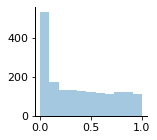

In [11]:
# Plot distribution of p-values, should see random distribution with a peak at 0
f, ax = plt.subplots(1, 1, figsize=(2, 2))
_ = sns.distplot(results_closest_pairs.ttest_p.values, kde=False, ax=ax)

### Closest pairs: overview
Can load results here for visualization

In [14]:
# Check how many potential SL pairs there are, and whether they include known SL pairs
def check_SLs(tested_pairs):
    SLs = tested_pairs[(tested_pairs.ttest_p_correct < 0.1) & 
                       (tested_pairs.A2_expr_A1_NE > tested_pairs.A2_expr_A1_E)]
    if SLs.shape[0] != SLs.A1.nunique():
        print('Num SL pairs:', SLs.shape[0], '/', tested_pairs.shape[0])
    print('Num SL A1s: %d / %d, ~%.3f%%' % (SLs.A1.nunique(), tested_pairs.A1.nunique(), 
                                            SLs.A1.nunique()/tested_pairs.A1.nunique() * 100))
    known_pairs = [('SMARCA2', 'SMARCA4'), ('SMARCA4', 'SMARCA2'), ('ARID1B', 'ARID1A'), ('STAG1', 'STAG2'),
                   ('RPL22L1', 'RPL22'), ('ENO1', 'ENO2')]
    for pair in known_pairs:
        if not (SLs[(SLs.A1 == pair[0]) & (SLs.A2 == pair[1])].shape[0] == 1):
            print(pair[0],'-',pair[1], ': not SL but expected to be')

In [15]:
# LOAD: Can also just read in the results that were previously computed
results_closest_pairs = pd.read_csv(file_results_closest)
check_SLs(results_closest_pairs)

Num SL A1s: 238 / 1819, ~13.084%


In [16]:
# SL pairs overview - INTERACTIVE 
# (only need to load the results_closest_pairs file to run this cell)
hover = alt.selection_single(on='mouseover', nearest=True, empty='none')
alt.Chart(
    results_closest_pairs.assign(SL_label=results_closest_pairs.SL.apply(
            lambda x: 'Potential synthetic lethal paralog pair' if x==True else 'Tested paralog pair'))
).mark_circle(size=30, opacity=0.7).encode(
    alt.X('A2_expr_A1_NE:Q', axis=alt.Axis(title='Average expression of A2 when A1 is not essential', 
                                           titleFontWeight='normal', titleFontSize=13, labelFontSize=11)),
    alt.Y('A2_expr_A1_E:Q', axis=alt.Axis(title='Average expression of A2 when A1 is essential', 
                                          titleFontWeight='normal', titleFontSize=13, labelFontSize=11)),
    color=alt.condition(hover, alt.ColorValue('#d95f02'), 'SL_label:N',
                        legend=alt.Legend(title=None, labelFontSize=13, fillColor='#FFFFFF', cornerRadius=2, 
                                         strokeColor='#DDDDDD', padding=5, orient='top', columns=1, labelLimit=250), 
                        scale=alt.Scale(domain=['Potential synthetic lethal paralog pair', 'Tested paralog pair'], 
                                        range=['#1b9e77', 'lightgrey'])),
    tooltip=['A1:N', 'A2:N', alt.Tooltip('SL:N', title='potential SL')],
    order='SL:N'
).properties(width=300, height=300).add_selection(hover)

alt.Chart(...)

In [17]:
def annotate_pairs(ax, df, pairs, fontsize=11):
    pairs_to_annotate = df[df[['A1','A2']].apply(tuple, axis=1).isin(pairs)]
    x_offsets = {'RPL22L1':-0.18, 'MAGOH':0.4, 'DDX5':-3.3}
    y_offsets = {'SEC23B':-0.35, 'STAG1':0.1, 'RPL22L1':-0.5, 'FERMT1':-0.3, 'FAM126B':-0.3, 'PRDX1':-0.2}
    for idx in pairs_to_annotate.index:
        label = pairs_to_annotate.A1[idx] + ', '+ pairs_to_annotate.A2[idx]
        if pairs_to_annotate.A1[idx] in x_offsets: x_offset = x_offsets[pairs_to_annotate.A1[idx]]
        else: x_offset = 0.2 # default
        if pairs_to_annotate.A1[idx] in y_offsets: y_offset = y_offsets[pairs_to_annotate.A1[idx]]
        else: y_offset = -0.1 # default
        ax.text(pairs_to_annotate.A2_expr_A1_NE[idx] + x_offset, pairs_to_annotate.A2_expr_A1_E[idx] + y_offset, 
                label, horizontalalignment='left', color="gray", style='italic', fontsize=fontsize)

def draw_scatterplot_for_SL_pairs(df, ax, hue='WGD'):
    hue_order = ['WGD','SSD']
    if hue=='either_in_complex': hue_order = [True, False]
    sns.scatterplot(data=df[~df.SL], x='A2_expr_A1_NE', y='A2_expr_A1_E', ax=ax, s=28, linewidth=0, 
                    alpha=0.4, color='silver', legend=False)
    sns.scatterplot(data=df[df.SL], x='A2_expr_A1_NE', y='A2_expr_A1_E', ax=ax, s=28, linewidth=0,
                    alpha=0.7, hue=hue, palette=get_color_palette(4), hue_order=hue_order, zorder=10)
    ax.set_xlabel('Mean expression of A2 where A1 is not essential')
    ax.set_ylabel('Mean expression of A2 where A1 is essential')
    ax.grid(axis='y', color='#DDD'); ax.grid(axis='x', color='#DDD')
    ax.set_xlim([-0.5,12.01]); ax.set_ylim([-0.5,12])
    handles, labels = ax.get_legend_handles_labels()
    legend_title = 'Duplication mode:'
    if hue=='either_in_complex': legend_title = 'Either in complex:'
    _ = ax.legend(handles=handles[1:], labels=labels[1:], framealpha=1, loc='upper left', title=legend_title, ncol=2)

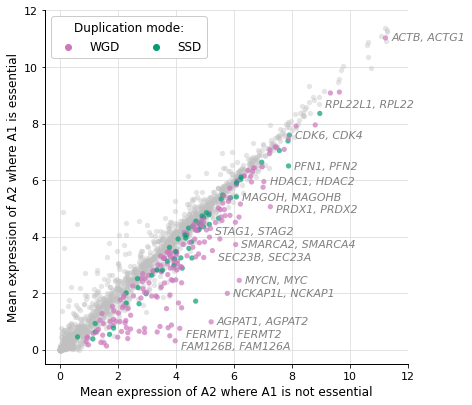

In [18]:
pairs_to_annotate = [
    ('SMARCA2', 'SMARCA4'), ('FAM126B', 'FAM126A'), ('AGPAT1', 'AGPAT2'), ('PRDX1', 'PRDX2'), ('HDAC1', 'HDAC2'), 
    ('RPL22L1', 'RPL22'), ('NCKAP1L', 'NCKAP1'), ('SEC23B', 'SEC23A'), ('CDK6', 'CDK4'), ('PFN1', 'PFN2'), 
    ('FERMT1', 'FERMT2'), ('MAGOH', 'MAGOHB'), ('MYCN', 'MYC'), ('STAG1', 'STAG2'), ('ACTB', 'ACTG1')
]
# Color according to WGD vs. SSD
with mpl.rc_context({'legend.fontsize':12}):
    f, ax = plt.subplots(1, 1, figsize=(6.5, 6.5))
    draw_scatterplot_for_SL_pairs(results_closest_pairs, ax)
    annotate_pairs(ax, results_closest_pairs, pairs_to_annotate)
    #plt.savefig('../figures/fig_5B.svg',  bbox_inches='tight', dpi=300)

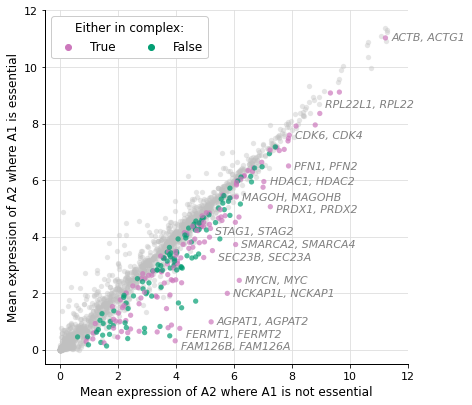

In [19]:
# Color according to complex membership
with mpl.rc_context({'legend.fontsize':12}):
    f, ax = plt.subplots(1, 1, figsize=(6.5, 6.5))
    draw_scatterplot_for_SL_pairs(results_closest_pairs, ax, hue='either_in_complex')
    annotate_pairs(ax, results_closest_pairs, pairs_to_annotate)
    #plt.savefig('../figures/fig_5B_complex.svg',  bbox_inches='tight', dpi=300)

#### Symmetric SL pairs

In [29]:
SLs = results_closest_pairs[results_closest_pairs.SL==True]
sorted_pairs = pd.DataFrame(np.sort(SLs[['A1','A2']]), columns=['A1','A2'])
print('Num symmetric pairs:', sum(sorted_pairs.duplicated(subset=['A1','A2'])), '/', SLs.shape[0])

Num symmetric pairs: 12 / 238


### All pairs: compare A2 expression for A1 essential vs. A1 not essential

In [20]:
all_pairs = pd.read_csv(file_all_pairs, index_col=0)
print('Num closest pairs:', all_pairs.shape[0])
display(all_pairs[:1])

Num closest pairs: 57076


,A1_ensembl,A2_ensembl,percent_matched_in_paralog,min_seq_id,WGD,either_in_complex,in_same_complex,A1_symbol,A1_entrez,A2_symbol,A2_entrez,closest
0,ENSG00000092850,ENSG00000163060,0.293023,0.289655,WGD,False,False,TEKT2,27285,TEKT4,150483,False


In [21]:
# Filter to genes where: 
# A1 is sometimes essential - w/ essential in at least 1% of cell lines, and at most 90%
# A2 has expr data
essential_percents = (all_scores <= cutoff_score).sum() / all_scores.shape[0]
sometimes_essential_genes = essential_percents[(essential_percents >= 0.01) & (essential_percents <= 0.9)]
all_pairs_filtered = all_pairs[all_pairs.A1_entrez.isin(sometimes_essential_genes.index) & all_pairs.A2_ensembl.isin(expr.columns)]
print('All pairs to test:', all_pairs_filtered.shape[0], ', A1s:', all_pairs_filtered.A1_ensembl.nunique())

All pairs to test: 6279 , A1s: 1829


In [22]:
# Test if there is a significant difference in expression
results_all_pairs = test_pairs(all_pairs_filtered)
SLs = results_all_pairs[results_all_pairs.SL==True]
print('Num SL A1s: %d / %d --> %.2f%%' % (SLs.A1.nunique(), results_all_pairs.A1.nunique(), 
                                          SLs.A1.nunique() / results_all_pairs.A1.nunique() * 100))
results_all_pairs[:1]

C:\Users\Barbara\Anaconda3\envs\paralogEssential\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Barbara\Anaconda3\envs\paralogEssential\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Barbara\Anaconda3\envs\paralogEssential\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Num SL A1s: 302 / 1829 --> 16.51%


,A1,A2,ttest_p,A2_expr_A1_NE,A2_expr_A1_E,ttest_p_correct,SL,percent_matched_in_paralog,WGD,either_in_complex,in_same_complex,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez
0,TEKT2,TEKT4,0.160877,0.064105,0.023072,0.520612,False,0.293023,WGD,False,False,ENSG00000092850,ENSG00000163060,27285,150483


In [23]:
check_SLs(results_all_pairs)

Num SL pairs: 375 / 6278
Num SL A1s: 302 / 1829, ~16.512%


In [24]:
results_all_pairs.to_csv(file_results_all, index=0)

### All pairs: overview
Can load results here for visualization

In [25]:
# LOAD
results_all_pairs = pd.read_csv(file_results_all)
check_SLs(results_all_pairs)

Num SL pairs: 375 / 6278
Num SL A1s: 302 / 1829, ~16.512%


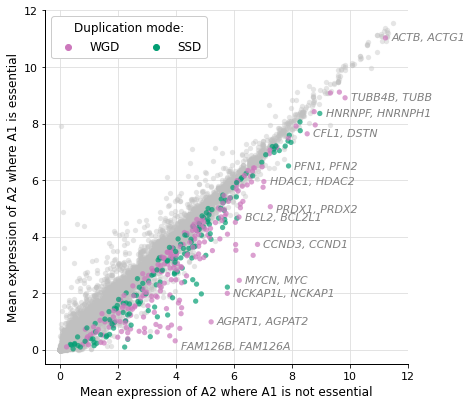

In [27]:
pairs_to_annotate = [('ACTB', 'ACTG1'), ('CFL1', 'DSTN'), ('PFN1', 'PFN2'), ('MYCN', 'MYC'), ('TUBB4B', 'TUBB'),
                     ('HNRNPF', 'HNRNPH1'), ('CCND3', 'CCND1'), ('PRDX1', 'PRDX2'), ('HDAC1', 'HDAC2'),
                     ('NCKAP1L', 'NCKAP1'), ('AGPAT1', 'AGPAT2'), ('FAM126B', 'FAM126A'), ('BCL2', 'BCL2L1')]
# Color according to WGD vs. SSD
with mpl.rc_context({'legend.fontsize':12}):
    f, ax = plt.subplots(1, 1, figsize=(6.5, 6.5))
    draw_scatterplot_for_SL_pairs(results_all_pairs, ax)
    annotate_pairs(ax, results_all_pairs, pairs_to_annotate)

plt.savefig('../figures/fig_S2B.svg',  bbox_inches='tight', dpi=300)

### Overlapping pairs

In [28]:
# Check overlap of closest and all pairs SLs
SLs1 = results_closest_pairs[results_closest_pairs.SL==True][['A1', 'A2']]
SLs2 = results_all_pairs[results_all_pairs.SL==True][['A1', 'A2']]
print('Total SLs: ' + str(SLs1.shape[0]) + ', ' + str(SLs2.shape[0]))
# Zip returns an iterator
set1 = set([(a1,a2) for a1, a2 in zip(SLs1.A1, SLs1.A2)])
set2 = set([(a1,a2) for a1, a2 in zip(SLs2.A1, SLs2.A2)])
print('Overlapping pairs: ' + str(len(set1.intersection(set2))))
print('Union of all pairs: ' + str(len(set1.union(set2))))

Total SLs: 238, 375
Overlapping pairs: 211
Union of all pairs: 402


### Example of lower A2 expression => A1 essential

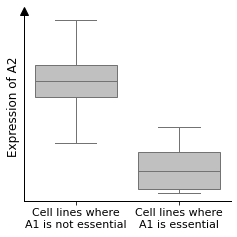

In [34]:
example_pair = results_closest_pairs[results_closest_pairs.A1=="SMARCA2"]
df = pd.DataFrame({'A2_expr': expr.loc[:, example_pair.A2_ensembl.values[0]], 
                   'A1_status': scores.loc[:, str(example_pair.A1_entrez.values[0])]})
labels = ['Cell lines where\nA1 is not essential', 'Cell lines where\nA1 is essential']
df.A1_status = df.A1_status.apply(lambda x: labels[1] if x <= -0.47 else labels[0])

f, ax = plt.subplots(1, 1, figsize=(3.7, 3.5))
sns.boxplot(x='A1_status', y='A2_expr', data=df, color='silver', ax=ax, order=labels, saturation=1, 
            linewidth=1, showfliers=False)
ax.set_ylabel("Expression of A2"); ax.set_xlabel('')
ax.set_xticklabels(labels, fontsize=11)
ax.plot(-0.5, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False, markersize=8)
_ = plt.yticks([])

plt.savefig('../figures/fig_5A.svg',  bbox_inches='tight', dpi=300)

### Plot known SL pairs

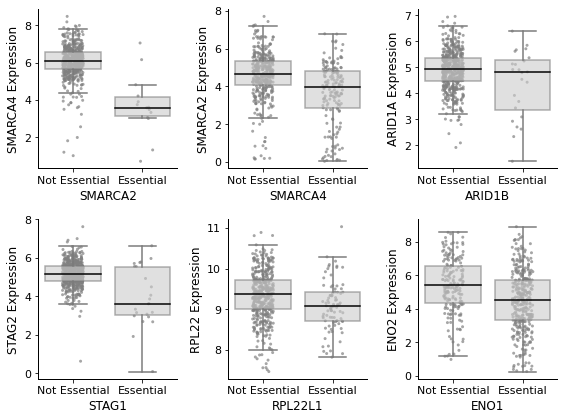

In [39]:
def plot_pair_boxplot(pair_to_plot, ax):
    pair = results_closest_pairs[(results_closest_pairs.A1==pair_to_plot[0]) & (results_closest_pairs.A2==pair_to_plot[1])]
    df = pd.DataFrame({'A2_expr': expr.loc[:, str(pair.A2_ensembl.values[0])], 
                       'A1_status': scores.loc[:, str(pair.A1_entrez.values[0])]})
    labels = ['Not Essential', 'Essential']
    df.A1_status = df.A1_status.apply(lambda x: labels[1] if x <= -0.47 else labels[0])
    sns.stripplot(data=df, x='A1_status', y='A2_expr', order=labels, color='grey', alpha=0.7, size=3, zorder=0, jitter=0.15, ax=ax)
    sns.boxplot(data=df, x='A1_status', y='A2_expr', ax=ax, order=labels, color='#ccc', 
                saturation=1, linewidth=1.5, showfliers=False, boxprops=dict(alpha=0.6), medianprops=dict(color='black'))
    ax.set_xlabel(pair_to_plot[0])
    ax.set_ylabel(pair_to_plot[1] + ' Expression')

f, axes = plt.subplots(2, 3, figsize=(8, 6))
axes = axes.flatten()
pairs_to_plot = [('SMARCA2', 'SMARCA4'), ('SMARCA4', 'SMARCA2'), ('ARID1B','ARID1A'), 
                 ('STAG1', 'STAG2'), ('RPL22L1', 'RPL22'), ('ENO1', 'ENO2')]
for i in range(0,6):
    plot_pair_boxplot(pairs_to_plot[i], axes[i])
plt.tight_layout()
plt.savefig('../figures/fig_5C.svg', bbox_inches='tight', dpi=300)